## 1. 概要

- データセットを作成するための計算を行った
  - SHGの変換効率について、近似解と解析解を計算して比較した
- 導波路に対してもpythonで計算ができるようにWGMODESをpythonに移植した

## 2. 計算

### SHG変換効率の数値解

- 変換効率は以下の式で表される。
$$
\eta = \frac{|B(L)|^2}{|A(0)|^2}
$$
  - $A(z)$ は入射光の振幅である。
  - $B(z)$ はSH光の振幅である。

- $A(z)$ と $B(z)$ は、以下の連立微分方程式を満たす。
$$
\frac{d}{dz}A(z) = -j\kappa^* A^*(z)B(z) \exp(j(2\Delta z))
$$
$$
\frac{d}{dz}B(z) = -j\kappa A(z)^2 \exp(j(2\Delta z))
$$

ただし、$\kappa$ および $2\Delta$ は次の式で定義される。

$$
\kappa^{(q)}_{NL} = \frac{2\omega \varepsilon_0}{4} \iint \left[ E^{2\omega}(x, y) \right]^* \mathbf{d_q}(x, y) \left[ E^{\omega}(x, y) \right]^2 dx\,dy
$$
$$
2\Delta^{(q)}_{SHG} = \beta^{2\omega} - \left( 2\beta^{\omega} + qK \right)
$$

ここで、$q$ はQPMの次数であり、通常は1次である。

- $L$ を変化させたグラフ

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from syuron import shg

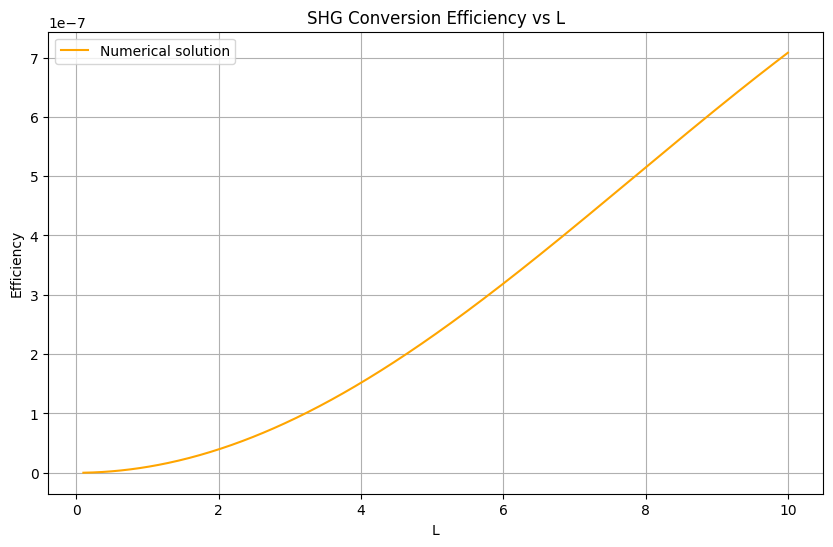

In [18]:
def L_vs_eff_numerical():
    # kappaとtwodelta関数の定義
    def kappa(z: float) -> complex:
        return 0.0001  # 小さい値を設定

    def twodelta(z: float) -> float:
        return 0.2

    # パラメータ設定
    A0 = 1.0 + 0j  # Initial condition for A(0)
    B0 = 0.0 + 0j  # Initial condition for B(0)
    L_values = np.linspace(0.1, 10, 600)

    # NMCEオブジェクトの作成
    nmce = shg.NMCE(kappa, twodelta)

    # 効率計算
    efficiency_values = []
    for L in L_values:
        B_L, A_z = nmce.solve(L, A0, B0)
        efficiency = shg.efficiency(B_L, A0)  # 効率を計算
        efficiency_values.append(efficiency)  # 効率をリストに追加

    return L_values, efficiency_values


# 効率を計算
L_approx, eff_vals = L_vs_eff_numerical()

# グラフの描画
plt.figure(figsize=(10, 6))

# Lに対する効率のプロット
plt.plot(L_approx, eff_vals, label='Numerical solution', color='orange')

plt.title('SHG Conversion Efficiency vs L')
plt.xlabel('L')
plt.ylabel('Efficiency')
plt.grid()
plt.legend()
plt.show()

* $\Delta$を変化させたグラフ

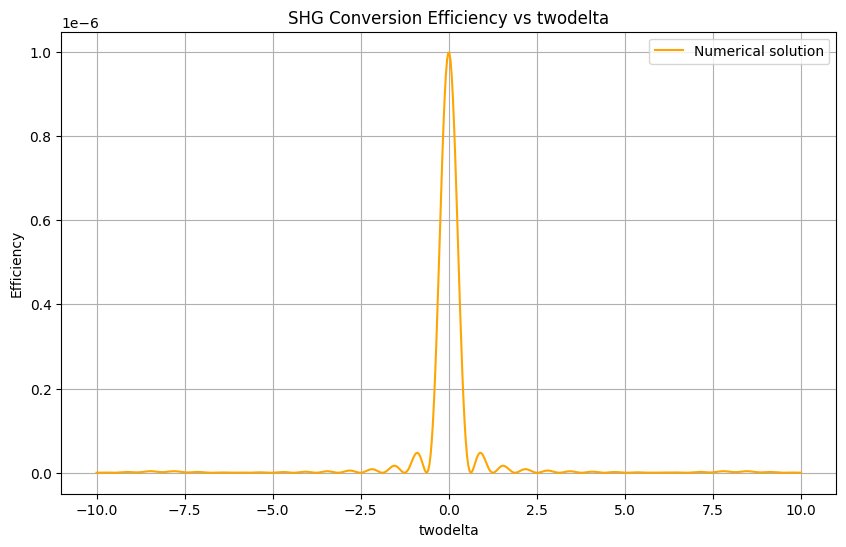

In [19]:
def twodelta_vs_eff_numerical():
    # kappa 関数の定義
    def kappa(z: float) -> complex:
        return 0.0001  # 小さい値を設定

    # パラメータ設定
    A0 = 1.0 + 0j  # A(0) の初期条件
    B0 = 0.0 + 0j  # B(0) の初期条件
    L = 10  # L を固定
    twodelta_values = np.linspace(-10, 10, 600)

    # 効率計算
    efficiency_values = []
    for twodelta_value in twodelta_values:
        # twodelta(z) 関数を定義（z に依存しない定数を返す）
        def twodelta(z: float) -> float:
            return twodelta_value

        # NMCE オブジェクトの作成
        nmce = shg.NMCE(kappa, twodelta)

        # 効率計算
        B_L, A_z = nmce.solve(L, A0, B0)
        efficiency = shg.efficiency(B_L, A0)  # 効率を計算
        efficiency_values.append(efficiency)  # 効率をリストに追加

    return twodelta_values, efficiency_values


# 効率を計算
twodelta_vals, eff_vals = twodelta_vs_eff_numerical()

# グラフの描画
plt.figure(figsize=(10, 6))

# twodelta に対する効率のプロット
plt.plot(twodelta_vals, eff_vals, label='Numerical solution', color='orange')

plt.title('SHG Conversion Efficiency vs twodelta')
plt.xlabel('twodelta')
plt.ylabel('Efficiency')
plt.grid()
plt.legend()
plt.show()

### 近似解の解析解

$\kappa$と$\Delta$が小さい時、変換効率が小さく、変換効率が小さい時以下のように近似できる

$$
\eta = \kappa^2 P_0 L^2 \left( \frac{\sin (\Delta L)}{\Delta L} \right)^2
$$

- $L$を変化させたグラフ

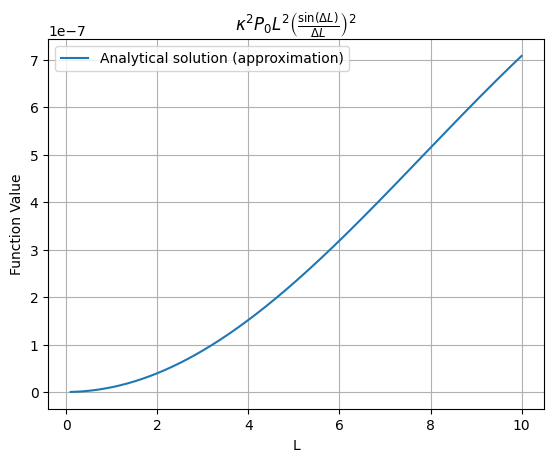

In [20]:
def L_vs_eff_analytical():
    kappa = 0.0001  # 小さい値を設定
    Delta = 0.1  # twodeltaの半分の値を設定
    A0 = 1.0
    P_0 = A0**2

    # Lの範囲を定義
    L = np.linspace(0.1, 10, 1000)

    # 近似関数
    def function(L, kappa, P_0, Delta):
        return kappa**2 * P_0 * L**2 * (np.sin(Delta * L) / (Delta * L))**2

    y_values = function(L, kappa, P_0, Delta)

    return L, y_values


L_approx, y_vals_approx = L_vs_eff_analytical()

plt.plot(L_approx, y_vals_approx, label="Analytical solution (approximation)")
plt.xlabel('L')
plt.ylabel('Function Value')
plt.title(
    r'$\kappa^2 P_0 L^2 \left( \frac{\sin (\Delta L)}{\Delta L} \right)^2$')
plt.grid(True)
plt.legend()
plt.show()

* $\Delta$を変化させたグラフ

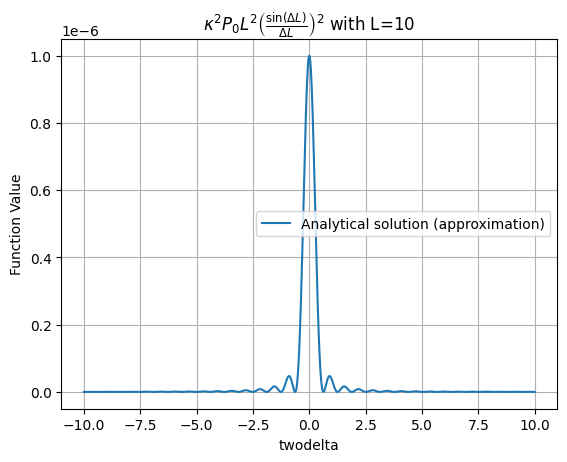

In [21]:
def twodelta_vs_eff_analytical():
    kappa = 0.0001  # 小さい値を設定
    L = 10  # Lを固定
    A0 = 1.0
    P_0 = A0**2

    # twodeltaの範囲を定義
    twodelta = np.linspace(-10, 10, 1000)

    # 近似関数
    def function(twodelta, kappa, P_0, L):
        Delta = twodelta / 2  # Deltaをtwodeltaの半分に設定
        return kappa**2 * P_0 * L**2 * (np.sin(Delta * L) / (Delta * L))**2

    y_values = function(twodelta, kappa, P_0, L)

    return twodelta, y_values


twodelta_vals_approx, y_vals_approx = twodelta_vs_eff_analytical()

plt.plot(twodelta_vals_approx, y_vals_approx,
         label='Analytical solution (approximation)')
plt.xlabel('twodelta')
plt.ylabel('Function Value')
plt.title(
    r'$\kappa^2 P_0 L^2 \left( \frac{\sin (\Delta L)}{\Delta L} \right)^2$ with L=10')
plt.grid(True)
plt.legend()
plt.show()

### 近似解と解析解の比較

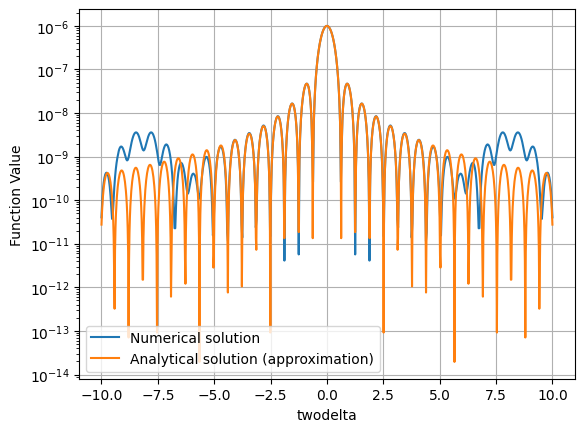

In [22]:
plt.plot(*twodelta_vs_eff_numerical(), label="Numerical solution")
plt.plot(*twodelta_vs_eff_analytical(),
         label="Analytical solution (approximation)")
plt.xlabel('twodelta')
plt.ylabel('Function Value')
plt.grid(True)
plt.yscale("log")
plt.legend()
plt.show()

## 3. 次にやること

* 卒論の訂正
* デバイスの概略図を書く
* データセットを作成する
    * 入力は$\Delta$の配列
    * 出力はスペクトル分布
    
# 11/15の週報
  
## やることの整理

```mermaid
mindmap
  root((入射波に対する柔軟な
    波長依存性を持つ
    波長変換デバイスの設計))
    (順問題)
      (シミュレーション)
        (FDTD解析)
        (BPM法)
        (結合モード理論)
      (性能評価)
        (波長特性)
        (変換効率)
        (温度依存性)
    (逆問題による構造設計)
      (機械学習アプローチ)
        (学習データ生成)
          (構造パラメータの網羅的計算)
          (特性データベース構築)
        (モデル構築)
          (ニューラルネットワーク設計)
          (損失関数の定義)
          (学習・検証)
        (最適化)
          (目標特性からの構造導出)
          (多目的最適化)
      (設計制約)
        (製造可能性)
        (構造パラメータの範囲)
        (材料限界)
    (材料特性)
      (非線形光学効果)
        (位相整合条件)
        (変換効率)
      (分散特性)
        (群速度分散)
        (位相速度)
    (実験検証)
      (デバイス作製)
        (リソグラフィ)
        (エッチング)
      (特性評価)
        (予測値との比較)
        (モデル精度検証)
    (フィードバック)
      (実験結果の学習データへの反映)
      (モデルの更新・改良)
      (設計指針の確立)
```

## パラメータの整理

```mermaid
mindmap
  root((SHG変換効率
  のパラメータ))
    (結合係数 kappa)
      (意味)
        (非線形光学効果の強さ)
      (計算)
        (-波長に依存)
    (位相不整合 2delta)
      (意味)
        (基本波と高調波の位相差)
      (計算)
        (-波長に依存)
      (パラメータΛ)
        (分極反転周期)
        (-今回はこれを変化させてシミュレーションしたい)
    (伝搬長 L)
      (意味)
        (デバイス長)
      (計算)
        (固定でよさげ)
    (初期条件)
      (A0 入射基本波)
        (振幅 1.0)
        (パワーに換算可能)
      (B0 初期SH波)
        (通常は0)
        (初期位相0)
        (パワーに換算可能)
```

- ループの中ではkappaが変化
  - 波長依存性を持つため
- 個々の計算ではΛが変化
  - 最適なΛの配列を探索するのが目的
- 現在はΛを固定した状態でのkappa依存性がわかっている
  - 野呂さんのを表示してみたところkappaは1.30756E-05から1.29932E-05の範囲
  - 野呂さんのを表示してみたところdeltaは7.83E-03から-1.40E-03の範囲
  - 近似式による計算からsinc関数っぽい図が得られている
- NMCE解いて計算した結果と野呂さんの結果を比較する

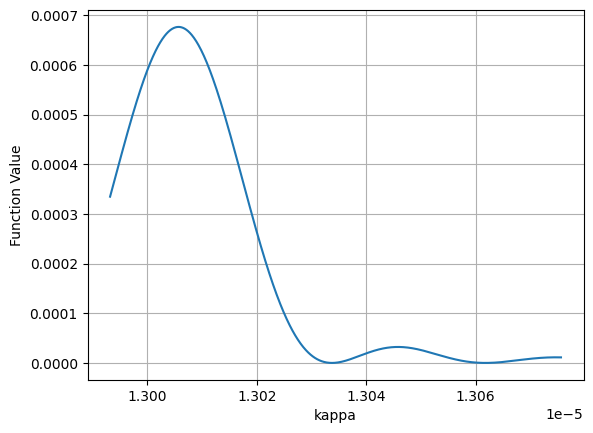

In [ ]:
def eff_analytical():
    # パラメータ設定
    A0 = 1.0 + 0j  # Initial condition for A(0)
    B0 = 0.0 + 0j  # Initial condition for B(0)
    P0 = A0**2
    L = 2000

    # kappaの範囲設定
    kappa_start = 1.30756E-05
    kappa_end = 1.29932E-05

    # deltaの範囲設定
    delta_start = 7.83E-03
    delta_end = -1.40E-03

    efficiency_values = []
    kappa_points = []

    # 1000回のループでkappaを線形的に変化させる
    for i in range(1000):
        # このループでのkappa値を計算（一定）
        t = i / 999  # 0 から 1 の間の比率
        kappa_value = kappa_start + (kappa_end - kappa_start) * t
        twodelta_value = delta_start + (delta_end - delta_start) * t

        # z依存性がなく個々のループ内では一定のkappaを返す関数
        def kappa(z: float) -> complex:
            return kappa_value

        # こちらもz依存性なし
        def twodelta(z: float) -> float:
            return twodelta_value

        kappa_points.append(kappa_value)

        nmce = shg.NMCE(kappa, twodelta)
        B_L, A_z = nmce.solve(L, A0, B0)
        efficiency = shg.efficiency(B_L, A0) / P0  # 効率を計算
        efficiency_values.append(efficiency)  # 効率をリストに追加

    return kappa_points, efficiency_values


plt.plot(*eff_analytical(), label="compare noro san graph")
plt.xlabel('kappa')
plt.ylabel('Function Value')
plt.grid(True)
plt.show()
